# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [1]:
# Imports

import calendar
from code_id_translator import *
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, fixed
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from neiss_backend_v8 import *
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import seaborn as sns
import sys
import xlrd



In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

## Read the pickled neissYYYY.xlsx file

xlsx_to_pckl.ipynb is used to create the pickled file

In [3]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    dfNeiss = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception('ERROR:  {} does not exist'.format(pckl_fname))


Reading /Users/mcorbett/Boston University/MET CS677 - Data Science with Python/Project/data/NEISS/neiss_data.pckl  ... done!


In [4]:
dfNeiss.shape

(361667, 19)

In [5]:
dfNeiss.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,180106119,2018-01-01,57,2,2,NaN,79,53,NaN,1,1,0,4074,611,57 YO F CAREGIVER WAS BATHING PT WHEN PT SLID ...,NaN,S,71,70.9703
1,180106122,2018-01-01,70,1,1,NaN,76,59,NaN,1,0,0,4057,0,70 YO M VOMITTING AND PASSED OUT HITTING HEAD ...,NaN,S,71,70.9703
2,180106156,2018-01-01,75,1,1,NaN,75,59,NaN,1,1,0,1807,0,75YOM-SCALP LAC-FELL HITTING HEAD ON CONCRETE ...,NaN,S,11,70.9703
3,180106157,2018-01-01,34,1,1,NaN,92,59,NaN,1,1,0,474,0,34YOM-FINGER LAC-CUT ON A BROKEN COFFEE MUG-@ ...,NaN,S,11,70.9703
4,180106178,2018-01-01,33,1,3,HISPANIC,92,59,NaN,1,1,0,464,0,33YOM WAS CUTTING LIMES WITH A KNIFE AND CUT L...,NaN,S,46,70.9703


### Update Neiss with column code dictionary from Excel file

In [6]:
column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [7]:
neiss = Neiss(dfNeiss)

In [8]:
dfNeiss.shape

(361667, 19)

### Time based graphs

/Users/mcorbett/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 2018.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


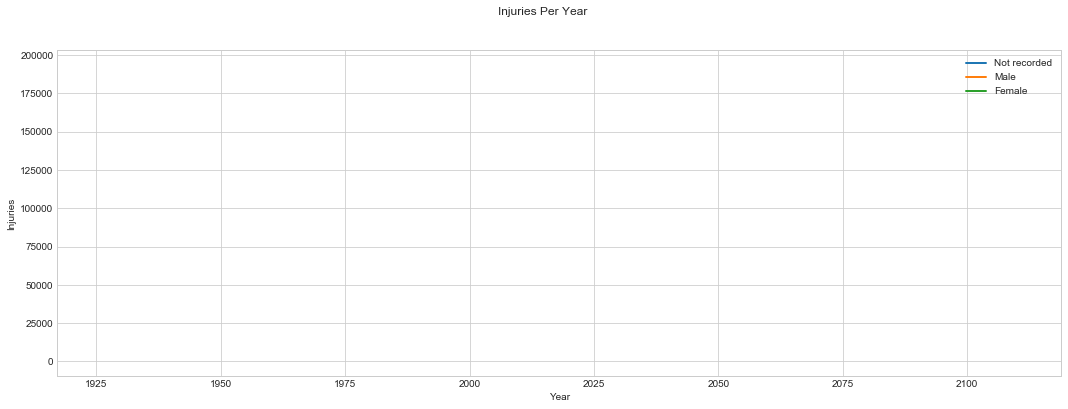

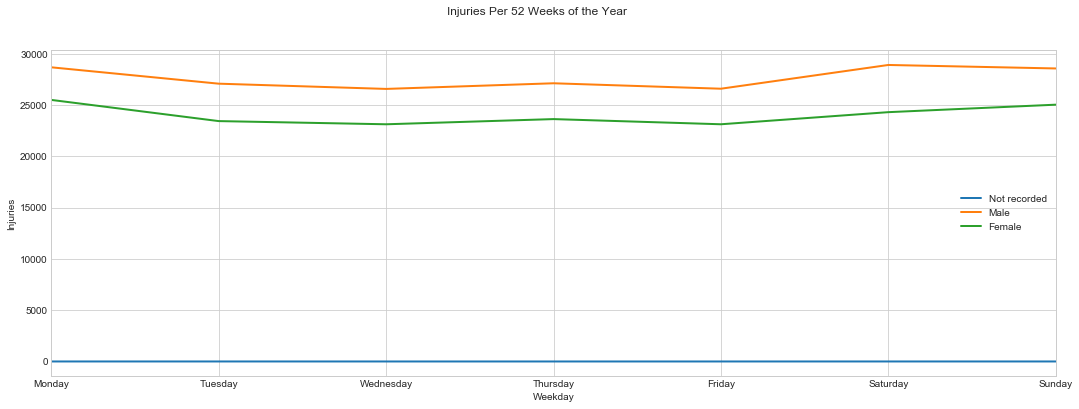

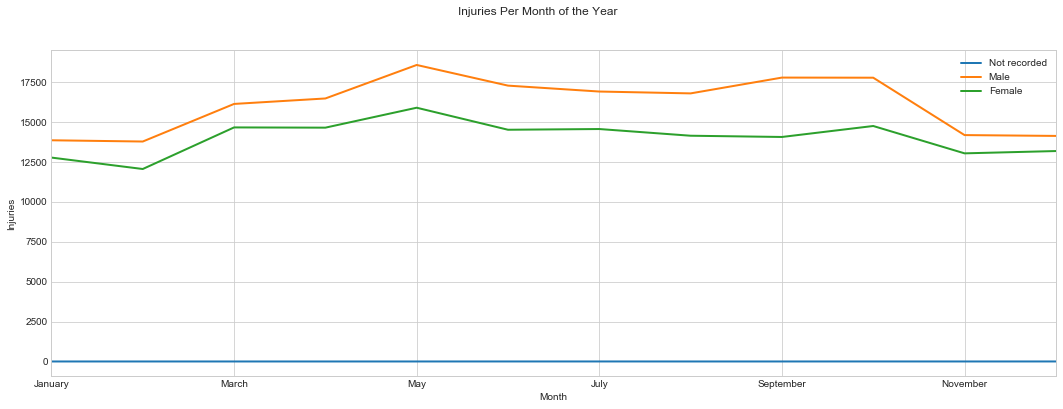

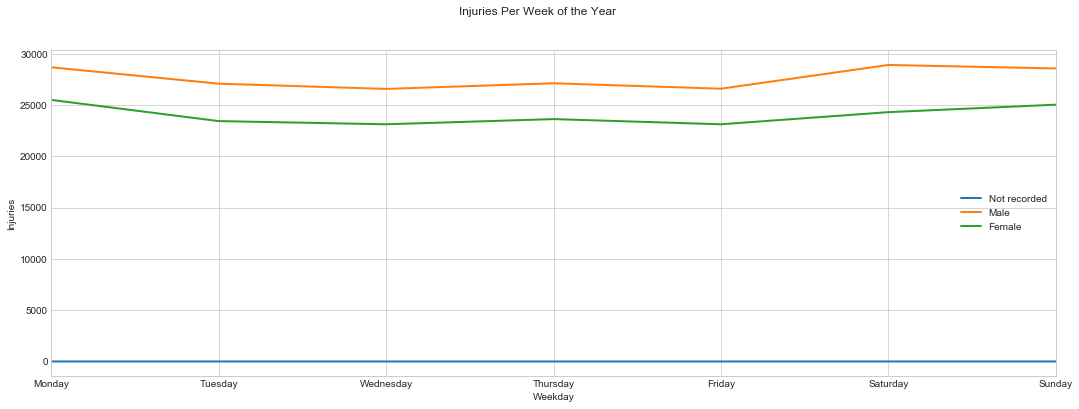

In [9]:
#df = neiss.getDataFrame()
date_name, stat_name = 'Treatment_Date', 'Sex'

showInjuriesPerYear(dfNeiss, date_name, stat_name, 'Injuries Per Year')
showInjuriesPerWeekOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per 52 Weeks of the Year')
showInjuriesPerMonthOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Month of the Year')
showInjuriesPerWeekOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Week of the Year')


### PearsonChiSquared

dfCategorical.head:
        Sex  Race  Body_Part  Diagnosis  Disposition  Location  \
214700    1     0         92         59            1         1   
182593    1     0          0         41            1         1   
137775    1     1         35         64            1         1   
76170     1     2         79         71            1         0   
60595     2     0         75         62            1         1   

        Fire_Involvement  Product_1  Product_2  PSU Stratum  
214700                 0       1426          0    7       S  
182593                 0       1686          0   17       V  
137775                 0       1807          0   95       V  
76170                  0       4014          0   41       V  
60595                  0        611          0    2       V  
code


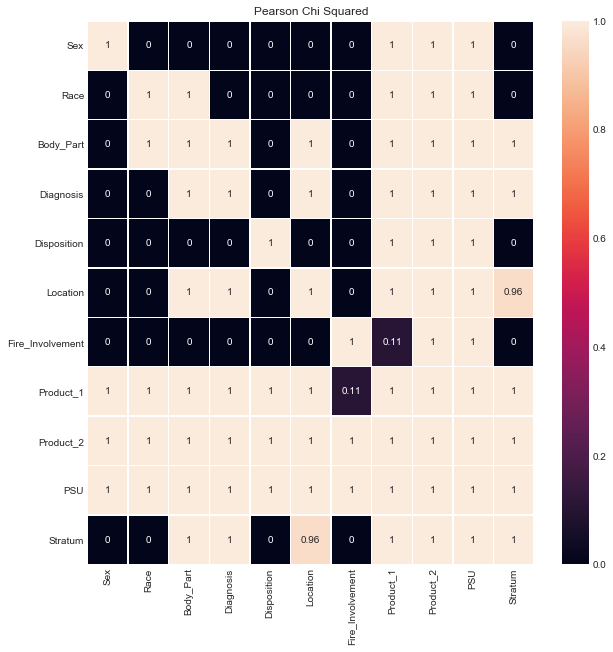

In [10]:
# build the correlation matrix (contingency table)
dfCategorical = dfNeiss.copy()
categorical = ['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 'Location',
               'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum' ]
dfCategorical = dfCategorical.xs(categorical, axis=1)
dfCategorical.dropna(inplace=True)
dfCategorical['Race'] = [int(x) for x in dfCategorical['Race']]
dfCategorical = dfCategorical.sample(3000)
print('dfCategorical.head:\n{}'.format(dfCategorical.head()))

codeIdTranslator = CodeIdTranslatorDataFrame(dfCategorical, categorical)
print(codeIdTranslator.state)
codeIdTranslator.transformColumns()

pcs1 = PearsonChiSquared(dfCategorical)
dfCategoricalCorrMatrix = pcs1.getCorrMatrixDataframe(categorical)


fig, ax = plt.subplots(figsize=(10, 10))

#sns.heatmap(dfCorrMatrix, annot=True, mask=mask, fmt="d", linewidths=0.4, ax=ax)
g = sns.heatmap(dfCategoricalCorrMatrix, annot=True, linewidths=0.4, ax=ax)
g.set_title('Pearson Chi Squared')
# Fix the top and bottom margins of the heatmap
bottom_y, top_y = plt.ylim() 
bottom_y += 0.5 
top_y -= 0.5 
plt.ylim(bottom_y, top_y)

plt.show() 

### Python Corr

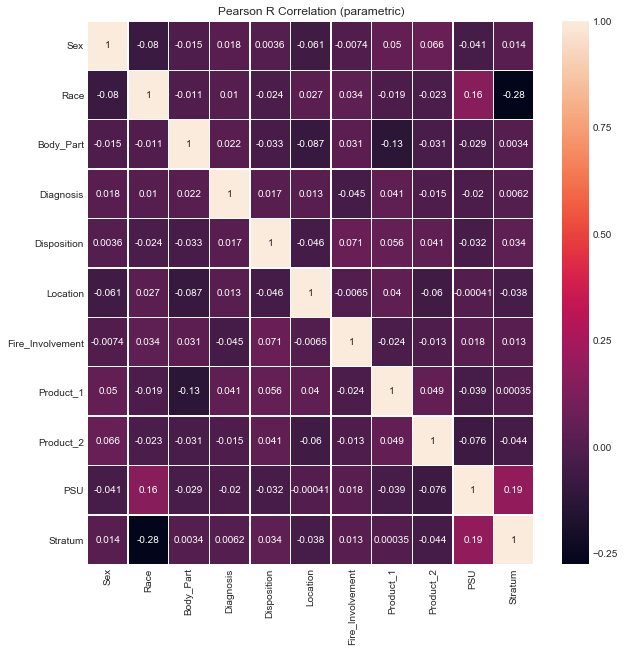

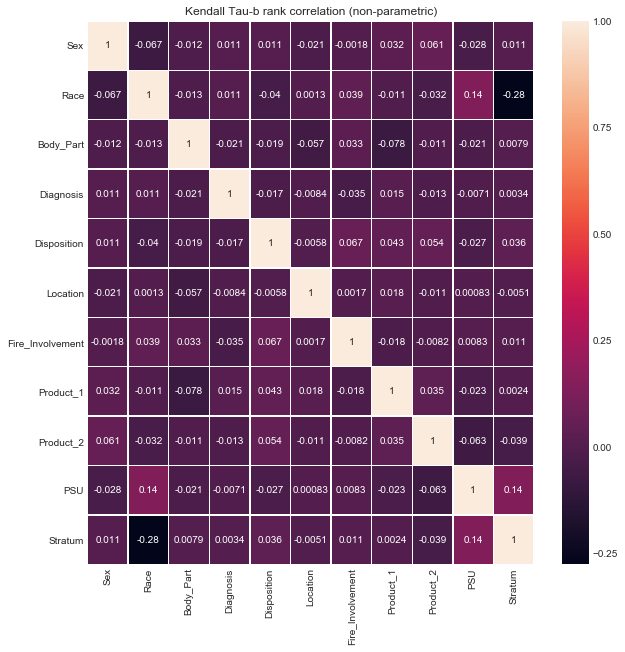

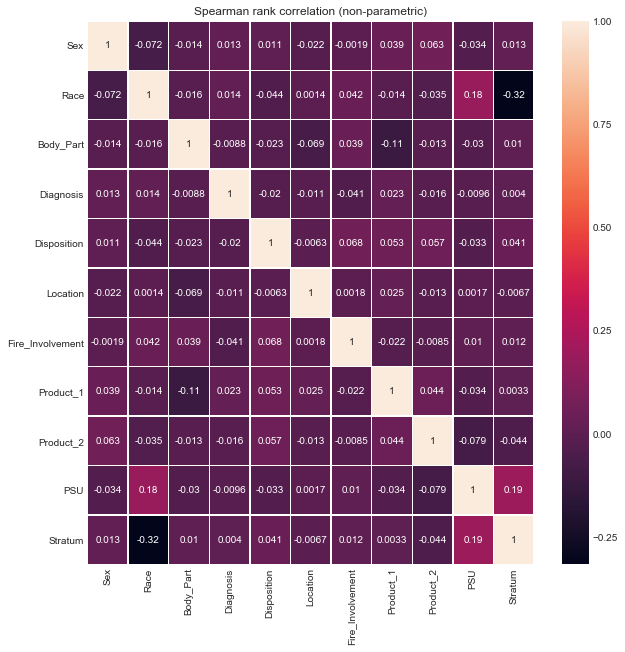

In [11]:

methods = {
    'pearson' : 'Pearson R Correlation (parametric)',  # not good for categorical data
        # For pearson:
        # both variables should be normally distributed
        # There should be no significant outliers
        # Each variable should be continuous
        # The two variables have a linear relationship
        # The observations are paired observations.
        # Should support homoscedascity.  Homoscedascity simply refers to ‘equal variances’.
    'kendall' : 'Kendall Tau-b rank correlation (non-parametric)',
        # The variables are measured on an ordinal or continuous scale.
        # Desirable if your data appears to follow a monotonic relationship.
    'spearman' : 'Spearman rank correlation (non-parametric)'
        # Does not assume that both datasets are normally distributed
    }


for key in methods.keys():
    dfCategoricalPythonCorr = dfCategorical.corr(method = key)

    fig, ax = plt.subplots(figsize=(10, 10))

    g = sns.heatmap(dfCategoricalPythonCorr, annot=True, linewidths=0.4, ax=ax)
    g.set_title(methods[key])

    # Fix the top and bottom margins of the heatmap
    bottom_y, top_y = plt.ylim() 
    bottom_y += 0.5 
    top_y -= 0.5 
    plt.ylim(bottom_y, top_y)

    plt.show() 


In [12]:
#sns.pairplot(df)

In [13]:
def getHighCorrelations(df, dfCategoricalCorrMatrix, minValue):
    high_correlations = []
    for yIndex, y in enumerate(dfCategoricalCorrMatrix.index):
        for xIndex, x in enumerate(dfCategoricalCorrMatrix.columns):
            #if xIndex >= yIndex:
            #    break

            if (x != y) and (dfCategoricalCorrMatrix[y][x] > minValue):
                Y = y
                X = x
                if len(df[X].unique()) > len(df[Y].unique()):
                    # Keep the smallest item on the X axis
                    Y, X = X, Y
                    
                if (Y, X) not in high_correlations:
                    high_correlations.insert(-1, (Y, X))
    high_correlations.sort()
    return high_correlations

high_correlations = getHighCorrelations(dfCategorical, dfCategoricalCorrMatrix, 0.95)
for n in high_correlations:
    print(n)

('Body_Part', 'Location')
('Body_Part', 'Race')
('Body_Part', 'Stratum')
('Diagnosis', 'Body_Part')
('Diagnosis', 'Location')
('Diagnosis', 'Stratum')
('Location', 'Stratum')
('PSU', 'Body_Part')
('PSU', 'Diagnosis')
('PSU', 'Disposition')
('PSU', 'Fire_Involvement')
('PSU', 'Location')
('PSU', 'Race')
('PSU', 'Sex')
('PSU', 'Stratum')
('Product_1', 'Body_Part')
('Product_1', 'Diagnosis')
('Product_1', 'Disposition')
('Product_1', 'Location')
('Product_1', 'PSU')
('Product_1', 'Product_2')
('Product_1', 'Race')
('Product_1', 'Sex')
('Product_1', 'Stratum')
('Product_2', 'Body_Part')
('Product_2', 'Diagnosis')
('Product_2', 'Disposition')
('Product_2', 'Fire_Involvement')
('Product_2', 'Location')
('Product_2', 'PSU')
('Product_2', 'Race')
('Product_2', 'Sex')
('Product_2', 'Stratum')


In [14]:
def chooseHighValueTargets(df, xSel, ySel, threshold):
    dfSel = df.xs([xSel, ySel], axis=1)
    s = dfSel.groupby(ySel).sum()
    s = s.sort_values(by=[xSel], ascending=False)
    cum = s[xSel].cumsum()
    maxAllowed = s[xSel].sum() * threshold
    print(maxAllowed)
    indices = cum[cum.values < maxAllowed].index

    print(len(dfSel))
    #[dfSel.drop(x)  if x not in indices for x in dfSel.index]
    #print(len(dfSel))
    return dfSel
    #return 0

#df1 = chooseHighValueTargets(df, xSel='Body_Part', ySel='Diagnosis', threshold=0.80)
#print(df1)


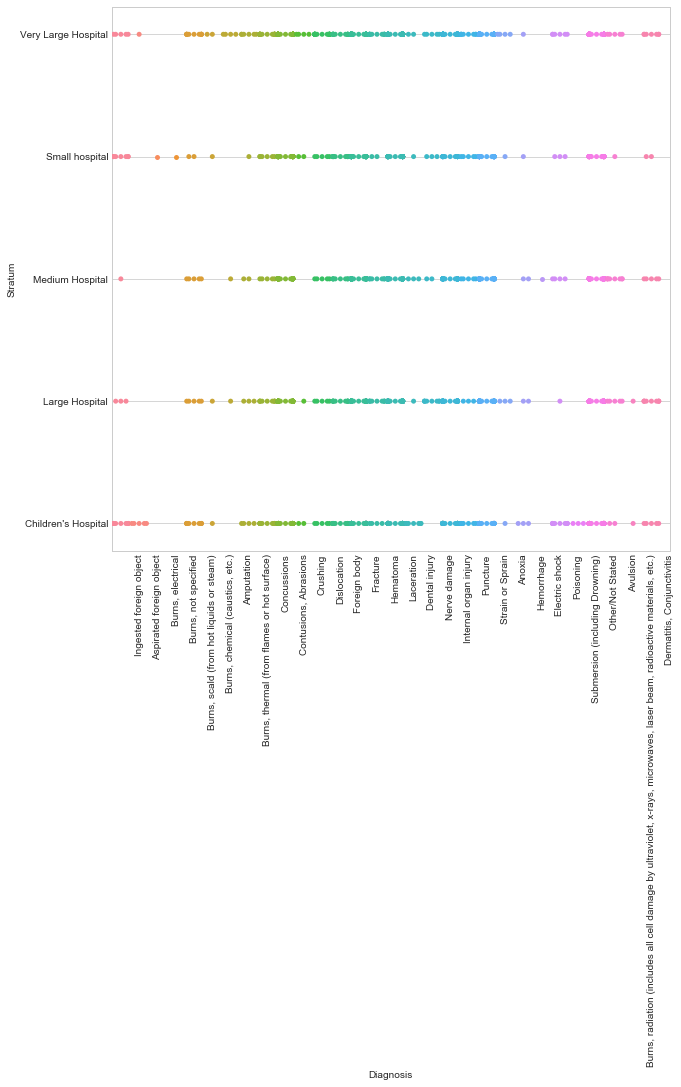

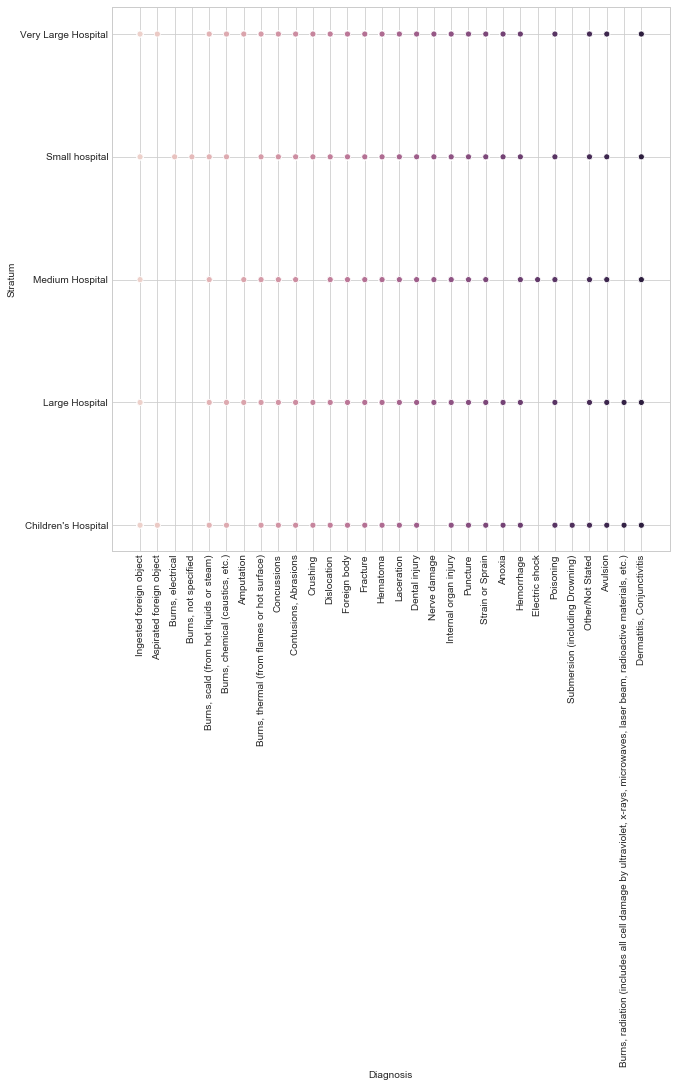

In [15]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

#print(high_correlations.values)
select = high_correlations[0]
#print(select)
lCorrelations = ['{}, {}'.format(y, x) for y, x in high_correlations]
correlationDropDownSel = widgets.Dropdown(
    options=lCorrelations,
    value=lCorrelations[0],
    description='correlations',
    disabled=False,
)

typeDropDownSel = widgets.Dropdown(
    options=['swarm', 'scatter'],
    value='swarm',
    description='plot_type',
    disabled=False,
)

wHBox = widgets.HBox([correlationDropDownSel, typeDropDownSel])
wVBox = widgets.VBox([wHBox, button, output])

display(wVBox)

def on_button_clicked(b):
    with output:
        sel = correlationDropDownSel.value
        (xSel, ySel) = [x.strip() for x in sel.split(',')]
        print('-{}-, -{}-'.format(xSel, ySel))
        
        #df1 = chooseHighValueTargets(df, xSel, ySel, threshold=0.80)

        
        correlations(codeIdTranslator, xSel, ySel, typeDropDownSel.value)

        #sns.pairplot(dfSel, hue=xSel)
button.on_click(on_button_clicked)
